In [ ]:
arquivo ='/content/gps_viagens.csv'


# Analise de Dados de Passageiros

## Preparação

In [ ]:
# Bibliotecas
import pandas as pd
import numpy as np
from datetime import datetime
import math
from scipy import stats
import statistics
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, max_error, r2_score, mean_squared_error,mean_absolute_error
import holidays
# from requests_html import HTMLSession

In [ ]:
# Paga dados da Base Filtrando por uma determinada Linha
def pega_dados(linha):
    df_iterator = pd.read_csv(arquivo, chunksize=2000)
    dataset = pd.DataFrame()
    for df in df_iterator:
        sdf = df[df['gps_codexterno_linha']==linha]
        dataset = pd.concat([dataset, sdf])
    return dataset
# Gava dados para posterior utilização
def grava_dados(df):
    df.to_csv('out.csv')
# Recupera dados anteriormente separados
def pega_dados_gravados():
    dataset = pd.read_csv('out.csv')
    return dataset

# Efetua a Exibição de dos Classificadores Escolhidos
def multi_class_classification( data_Y, predicted):
    max_erro = max_error(data_Y, predicted)
    r2score = r2_score(data_Y, predicted)
    mse = mean_squared_error(data_Y, predicted)
    rmse = math.sqrt(mse)
    mabse = mean_absolute_error(data_Y, predicted)
    print ("R2 Score ",r2score)
    print ("Erro Quadratico Médio ", mse)
    print ("Raiz Erro Quadratico Médio ",rmse)
    print ("Erro Quadratico Absoluto ",mabse)
    print ("Max Erro ",max_erro)
    return list([r2score,mse,rmse,mabse,max_erro])

## Pre-Processamento
Implementação Utilizada Atualmente
Média por, Linha, Hora, Tipo de Dia de um período semelhante(escolhido pela experiência do especialista).
m
é
d
i
a
=
∑
p
a
s
s
a
g
e
i
r
o
s
q
t
d
d
e
d
i
a
s
,
 por linha, hora e tipo de dia
Foi escolhida a importação de somente uma linha para a validação da implementação devido o grande volume de dados e por ser este o foco para reprogramação operacional que é sempre efetuada analisando-se a Linha

In [ ]:
# Importa dados de Seomente uma Linha
if 'dataset' not in locals():
    dataset = pega_dados('0518')
    grava_dados(dataset)
dataset=pega_dados_gravados()
analise_erros = dict()
dataset['gps_dataoperacao'].unique()

array(['2023-12-01', '2023-12-02', '2023-12-03', '2023-12-04',
       '2023-12-05', '2023-12-06', '2023-12-07', '2023-12-08',
       '2023-12-09', '2023-12-10', '2023-12-11', '2023-12-12',
       '2023-12-13', '2023-12-14', '2023-12-15', '2023-12-16',
       '2023-12-17', '2023-12-18', '2023-12-19', '2023-12-20',
       '2023-12-21', '2023-12-22', '2023-12-23', '2023-12-24',
       '2023-12-25', '2023-12-26', '2023-12-27', '2023-12-28',
       '2023-12-29', '2023-12-30', '2023-12-31', '2024-01-01',
       '2024-01-02', '2024-01-03', '2024-01-04', '2024-01-05',
       '2024-01-06', '2024-01-07', '2024-01-08', '2024-01-09',
       '2024-01-10', '2024-01-11', '2024-01-12', '2024-01-13',
       '2024-01-14', '2024-01-15', '2024-01-16', '2024-01-17',
       '2024-01-18', '2024-01-19', '2024-01-20', '2024-01-21',
       '2024-01-22', '2024-01-23', '2024-01-24', '2024-01-25',
       '2024-01-26', '2024-01-27', '2024-01-28', '2024-01-29',
       '2024-01-30'], dtype=object)

In [ ]:
# del dataset

In [ ]:
# Ajusta do Tipo de Dia
def uf_tipo_dia(d):
    tipo_dia = {
        0: 3,
        1: 1,
        2: 1,
        3: 1,
        4: 1,
        5: 1,
        6: 2
    }
    return tipo_dia.get(d, 1)
# Efetua o tratamento dos dados
def trata_dados(df):
    new_df = df.copy()
    new_df['gps_dataoperacao']=pd.to_datetime(new_df['gps_dataoperacao'], format="%Y-%m-%d")
    new_df['gps_datahora_saida']=pd.to_datetime(new_df['gps_datahora_saida'], format="%Y-%m-%d %H:%M:%S", dayfirst=True, errors='coerce')
    #new_df = new_df[pd.to_datetime(new_df['gps_datahora_saida']).notnull()]
    new_df['Hora Uso'] = new_df['gps_datahora_saida'].dt.hour
    new_df['diasemana'] = new_df['gps_dataoperacao'].dt.weekday
    new_df['tipodia'] = new_df['diasemana'].apply(lambda x: uf_tipo_dia(x))
    # new_df['Hora Uso'] = dataset['gps_datahora_saida'].apply(lambda x: x.split()[1])
    new_df = new_df.groupby(['gps_dataoperacao','tipodia' ,'gps_codexterno_linha', 'Hora Uso','gps_sentido','diasemana']).agg({'qtd_bilhetes': 'sum'}).reset_index()
    return new_df
# Efatua o Agrupamento das Informações
def agrupa_dados(df):
    dados = df.groupby(['tipodia' ,'gps_codexterno_linha', 'Hora Uso']).agg({'qtd_bilhetes': 'sum','gps_dataoperacao':pd.Series.nunique}).reset_index()
    dados['qtd_dias']=dados['gps_dataoperacao']
    dados.drop('gps_dataoperacao', axis=1, inplace=True)
    dados['PSH'] = round(dados['qtd_bilhetes'] / dados['qtd_dias'])
    return dados
def apaga_feriados(df):
    for data_feriado in feriados:
        registros = df[df['gps_dataoperacao']==data_feriado]
        df.drop(registros.index, axis=0,inplace=True)
    return df

In [ ]:
feriados= holidays.Brazil()
# Feriados Bahia
feriados['2024-07-02']='Independencia da Bahia'
# Feriados Salvador
feriados['2024-06-24']='São João'
print([(str(feriado),feriados[feriado]) for feriado in feriados['2024-01-01': '2024-12-31']])

[('2024-01-01', 'Confraternização Universal'), ('2024-03-29', 'Sexta-feira Santa'), ('2024-04-21', 'Tiradentes'), ('2024-05-01', 'Dia do Trabalhador'), ('2024-06-24', 'São João'), ('2024-07-02', 'Independencia da Bahia'), ('2024-09-07', 'Independência do Brasil'), ('2024-10-12', 'Nossa Senhora Aparecida'), ('2024-11-02', 'Finados'), ('2024-11-15', 'Proclamação da República'), ('2024-12-25', 'Natal')]


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3178 entries, 0 to 3177
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 3178 non-null   int64  
 1   gps_dataoperacao           3178 non-null   object 
 2   gps_codexterno_prefixo     3178 non-null   object 
 3   idgps_viagens              3178 non-null   int64  
 4   gps_codexterno_prefixo.1   3178 non-null   object 
 5   gps_tabela                 3178 non-null   object 
 6   gps_codexterno_linha       3178 non-null   int64  
 7   gps_linha_atendimento      3178 non-null   object 
 8   gps_sentido                3178 non-null   object 
 9   gps_datahora_saida         3178 non-null   object 
 10  gps_datahora_mudanca       0 non-null      float64
 11  gps_datahora_chegada       3178 non-null   object 
 12  gps_tipo_marcacao          3178 non-null   object 
 13  gps_linha_flg_circular     2889 non-null   objec

In [ ]:
# Carregando e Tratando os daso
tmp_dataset = trata_dados(dataset)
tmp_dataset = apaga_feriados(tmp_dataset)
# Limita para somente dias Útéis
tmp_dataset = tmp_dataset[tmp_dataset['tipodia']==1]
# Limita Horários
# tmp_dataset = tmp_dataset[tmp_dataset['Hora Uso']==17]
tmp_dataset = tmp_dataset[(tmp_dataset['gps_dataoperacao']>='2023-01-01') & (tmp_dataset['gps_dataoperacao']<='2023-12-31')]
tmp_dataset.head(5)

,gps_dataoperacao,tipodia,gps_codexterno_linha,Hora Uso,gps_sentido,diasemana,qtd_bilhetes
0,2023-12-01,1,518,4.0,I,4,76.0
1,2023-12-01,1,518,5.0,I,4,177.0
2,2023-12-01,1,518,5.0,V,4,97.0
3,2023-12-01,1,518,6.0,I,4,337.0
4,2023-12-01,1,518,6.0,V,4,174.0


In [ ]:
dataset['gps_dataoperacao'].unique()

array(['2023-12-01', '2023-12-02', '2023-12-03', '2023-12-04',
       '2023-12-05', '2023-12-06', '2023-12-07', '2023-12-08',
       '2023-12-09', '2023-12-10', '2023-12-11', '2023-12-12',
       '2023-12-13', '2023-12-14', '2023-12-15', '2023-12-16',
       '2023-12-17', '2023-12-18', '2023-12-19', '2023-12-20',
       '2023-12-21', '2023-12-22', '2023-12-23', '2023-12-24',
       '2023-12-25', '2023-12-26', '2023-12-27', '2023-12-28',
       '2023-12-29', '2023-12-30', '2023-12-31', '2024-01-01',
       '2024-01-02', '2024-01-03', '2024-01-04', '2024-01-05',
       '2024-01-06', '2024-01-07', '2024-01-08', '2024-01-09',
       '2024-01-10', '2024-01-11', '2024-01-12', '2024-01-13',
       '2024-01-14', '2024-01-15', '2024-01-16', '2024-01-17',
       '2024-01-18', '2024-01-19', '2024-01-20', '2024-01-21',
       '2024-01-22', '2024-01-23', '2024-01-24', '2024-01-25',
       '2024-01-26', '2024-01-27', '2024-01-28', '2024-01-29',
       '2024-01-30'], dtype=object)

In [ ]:
# Redução de dados
dados_tratados = tmp_dataset
dg = agrupa_dados(dados_tratados)
dados_tratados.set_index(['gps_dataoperacao'],inplace=True)

## Analise dos Dados

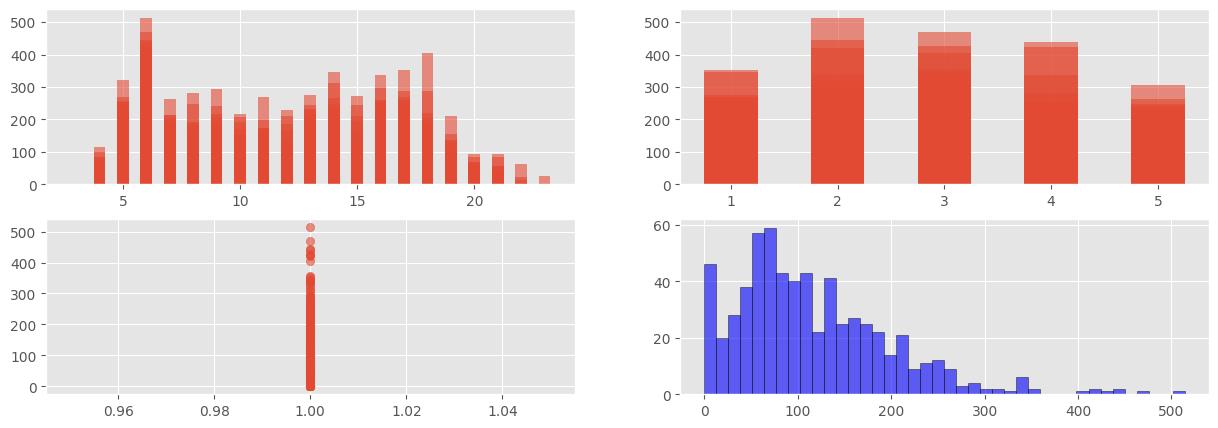

In [ ]:
plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = (15,5)
plt.subplot(2,2,1)
plt.bar(dados_tratados['Hora Uso'],dados_tratados['qtd_bilhetes'],0.5, align='center',alpha = .6)
plt.subplot(2,2,2)
plt.bar(dados_tratados['diasemana'],dados_tratados['qtd_bilhetes'],.5,align='center',alpha = .6)
plt.subplot(2,2,3)
plt.scatter(dados_tratados['tipodia'],dados_tratados['qtd_bilhetes'],alpha = .6)
plt.subplot(2,2,4)
plt.hist(dados_tratados['qtd_bilhetes'], ec = 'k',bins=40,color='b',alpha = .6)
plt.show()

<Axes: >

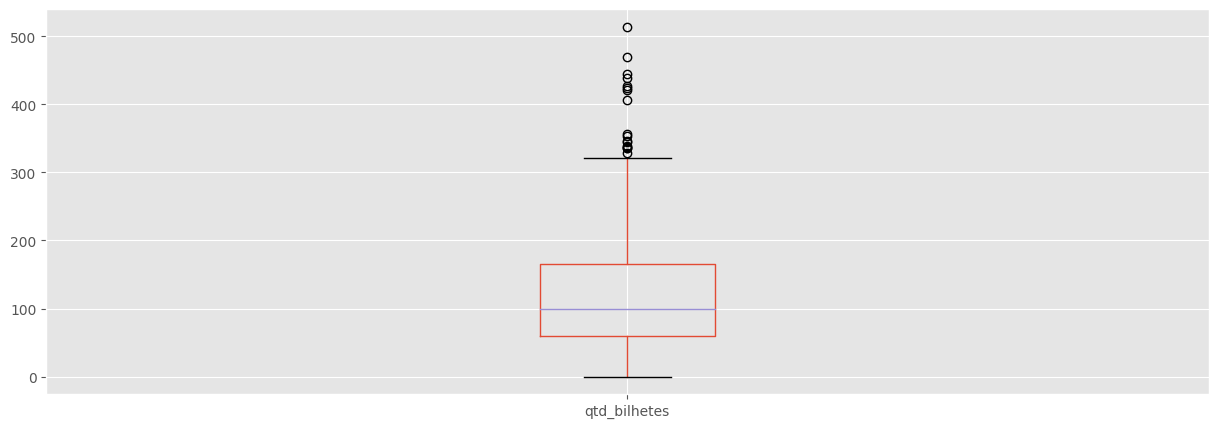

In [ ]:
dados_tratados[['qtd_bilhetes']].boxplot()

In [ ]:
resumo_dados = dados_tratados.groupby('gps_dataoperacao').agg({'qtd_bilhetes': 'sum'})

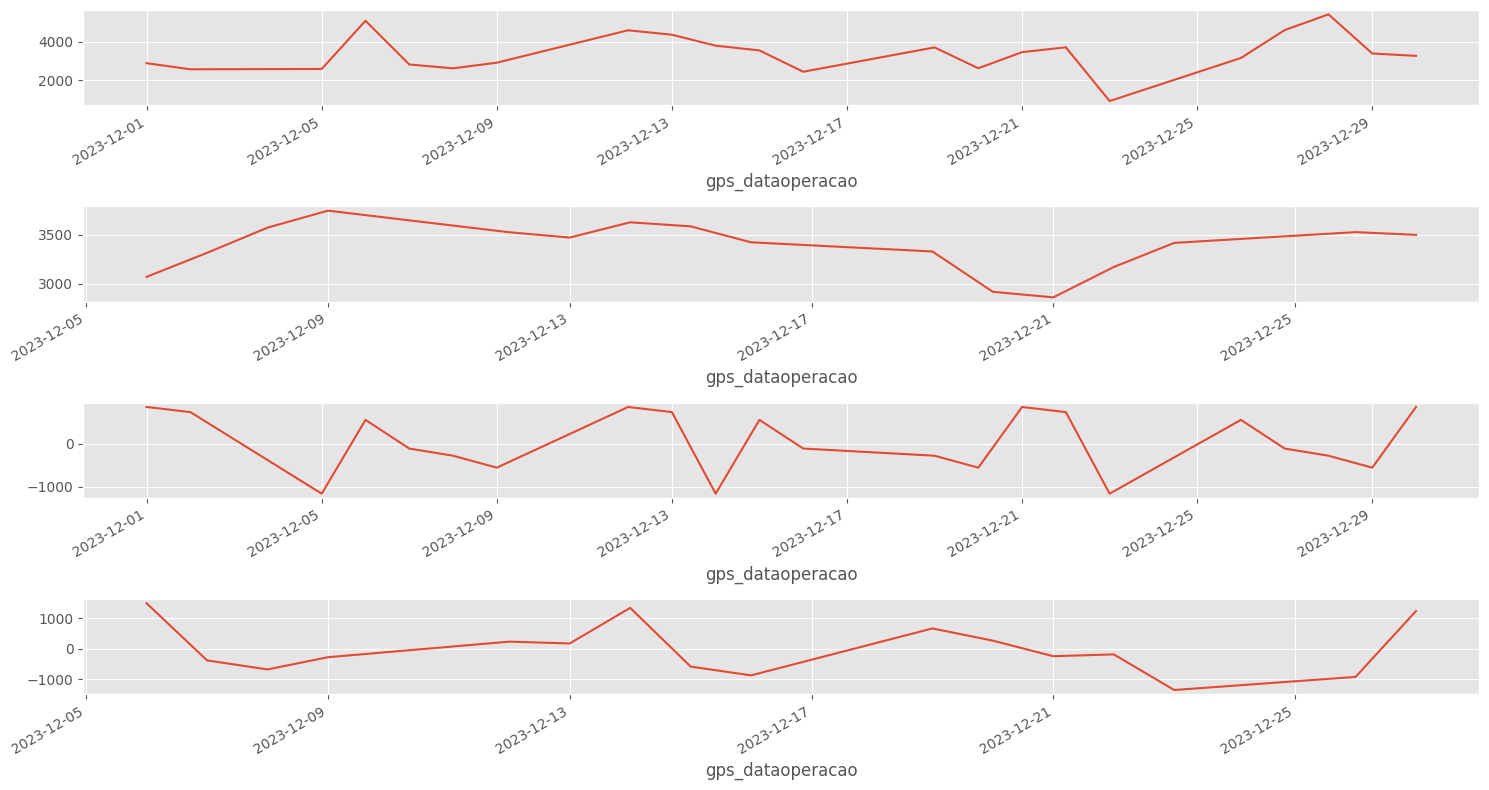

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
seasonplot = seasonal_decompose(resumo_dados['qtd_bilhetes'],period=7)
# plotar a decomposicao
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15,8))
seasonplot.observed.plot(ax=ax1)
seasonplot.trend.plot(ax=ax2)
seasonplot.seasonal.plot(ax=ax3)
seasonplot.resid.plot(ax=ax4)
plt.tight_layout()

In [ ]:
dados_tratados.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 640 entries, 2023-12-01 to 2023-12-30
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   tipodia               640 non-null    int64  
 1   gps_codexterno_linha  640 non-null    int64  
 2   Hora Uso              640 non-null    float64
 3   gps_sentido           640 non-null    object 
 4   diasemana             640 non-null    int64  
 5   qtd_bilhetes          640 non-null    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 35.0+ KB


## Implementa a Predição Atual

In [ ]:
# Implementa a Predição Atual
def predict_atual(df, linha, tpdia, hora):
    dados = df[(df['tipodia']==tpdia) & (df['Hora Uso']==hora) & (df['gps_codexterno_linha']==linha) ]
    if len(dados)>0:
        return int(dados['PSH'])
    else:
        return 0

r_atual = []
real = []
for i,p in dados_tratados.iterrows():
    r_atual.append(predict_atual(dg, p['gps_codexterno_linha'], p['tipodia'], p['Hora Uso']))
    real.append(p['qtd_bilhetes'])
erro_atual = multi_class_classification(real,r_atual)
analise_erros['ATUAL']=erro_atual

R2 Score  -0.9552035062451534
Erro Quadratico Médio  13694.1109375
Raiz Erro Quadratico Médio  117.02183957492721
Erro Quadratico Absoluto  92.4828125
Max Erro  419.0


In [ ]:
dados_prev = dados_tratados.copy()
dados_prev['PrevAtual'] = r_atual
dados_prev.head()

,tipodia,gps_codexterno_linha,Hora Uso,gps_sentido,diasemana,qtd_bilhetes,PrevAtual
gps_dataoperacao,,,,,,,
2023-12-01,1,518,4.0,I,4,76.0,38
2023-12-01,1,518,5.0,I,4,177.0,274
2023-12-01,1,518,5.0,V,4,97.0,274
2023-12-01,1,518,6.0,I,4,337.0,467
2023-12-01,1,518,6.0,V,4,174.0,467


In [ ]:
resumo_dados = dados_prev.groupby('gps_dataoperacao').agg({'qtd_bilhetes': 'sum','PrevAtual': 'sum'})
resumo_dados.head(5)

,qtd_bilhetes,PrevAtual
gps_dataoperacao,,
2023-12-01,2884.0,5174
2023-12-02,2566.0,5322
2023-12-05,2582.0,4477
2023-12-06,5107.0,6339
2023-12-07,2818.0,4914


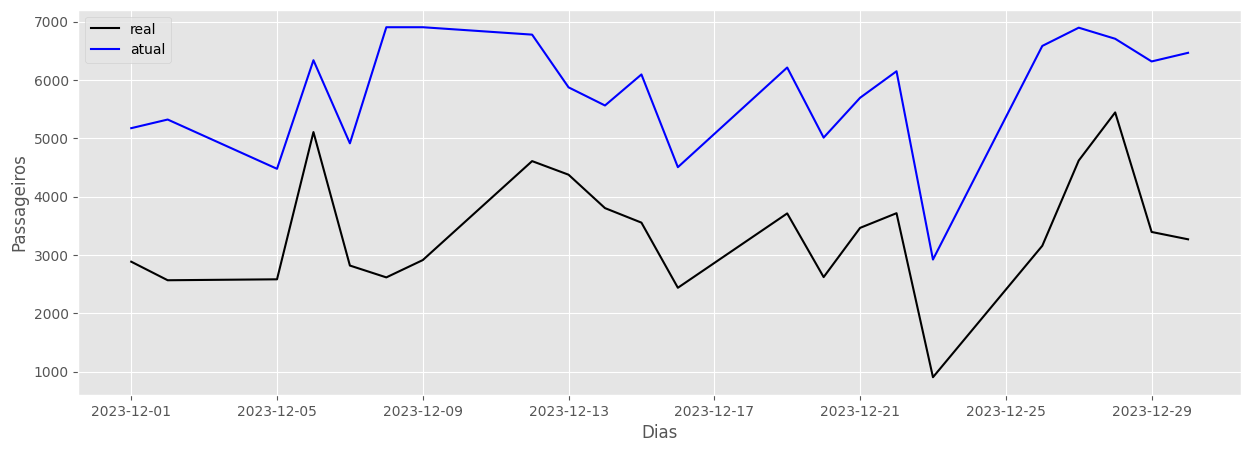

In [ ]:
plt.style.use("ggplot")
plt.plot(resumo_dados['qtd_bilhetes'].head(30), label='real', color='black', linewidth=1.5)
plt.plot(resumo_dados['PrevAtual'].head(30), label='atual', color='blue', linewidth=1.5)
plt.ylabel('Passageiros')
plt.xlabel('Dias')
plt.legend()
plt.show()

## Analisando com KNN Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
x_train = dados_tratados[['tipodia','Hora Uso','diasemana']]
y_train = real

In [ ]:
analise_erros

{'ATUAL': [-0.9552035062451534,
  13694.1109375,
  117.02183957492721,
  92.4828125,
  419.0]}

In [ ]:
menor_erro = 9999
k_ideal = 0
r_knnc = []
for k in range(60):
    clf = KNeighborsClassifier(n_neighbors=k+1)
    clf.fit(x_train, y_train)
    r_temp = clf.predict(x_train)
    e = mean_squared_error(real, r_temp)
    if e < menor_erro:
        menor_erro = e
        k_ideal = k+1
        r_knnc = r_temp
        print(e)
if k_ideal>0:
    print('K Ideal: ',k_ideal)
    analise_erros['R_KNNC']=multi_class_classification(real,r_knnc)

6202.3890625
5933.4671875
K Ideal:  2
R2 Score  0.15283760281056447
Erro Quadratico Médio  5933.4671875
Raiz Erro Quadratico Médio  77.02900224915288
Erro Quadratico Absoluto  52.3796875
Max Erro  372.0


In [ ]:
dados_prev['KNNC'] = r_knnc
dados_prev.head()

,tipodia,gps_codexterno_linha,Hora Uso,gps_sentido,diasemana,qtd_bilhetes,PrevAtual,KNNC
gps_dataoperacao,,,,,,,,
2023-12-01,1,518,4.0,I,4,76.0,38,0.0
2023-12-01,1,518,5.0,I,4,177.0,274,97.0
2023-12-01,1,518,5.0,V,4,97.0,274,97.0
2023-12-01,1,518,6.0,I,4,337.0,467,174.0
2023-12-01,1,518,6.0,V,4,174.0,467,174.0


In [ ]:
resumo_dados = dados_prev.groupby('gps_dataoperacao').agg({'qtd_bilhetes': 'sum','PrevAtual': 'sum','KNNC': 'sum'})
resumo_dados.head(5)

,qtd_bilhetes,PrevAtual,KNNC
gps_dataoperacao,,,
2023-12-01,2884.0,5174,1649.0
2023-12-02,2566.0,5322,2113.0
2023-12-05,2582.0,4477,2055.0
2023-12-06,5107.0,6339,3003.0
2023-12-07,2818.0,4914,2190.0


## KNN Classifier

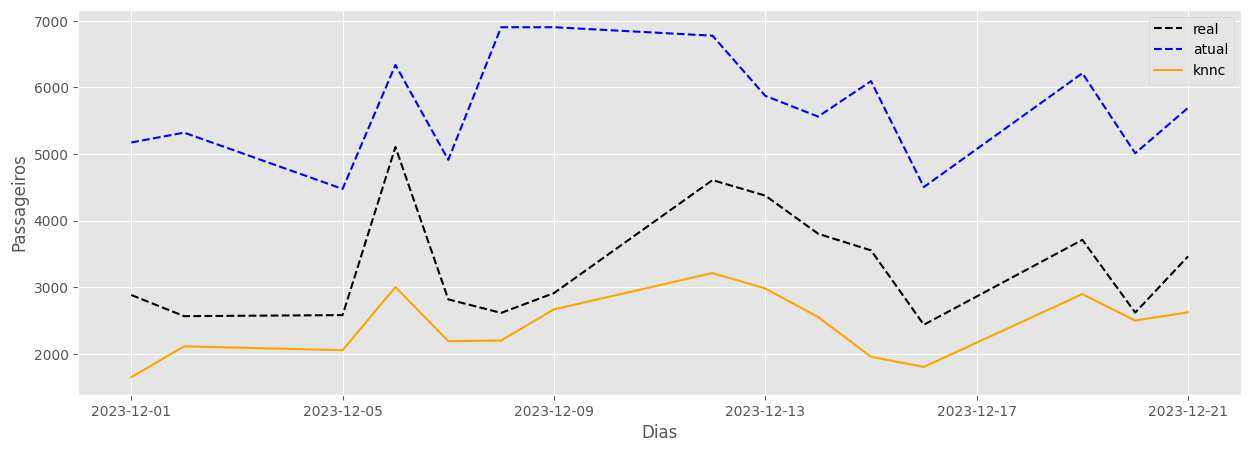

In [ ]:
plt.style.use("ggplot")
plt.plot(resumo_dados['qtd_bilhetes'].head(15),'--', label='real', color='black', linewidth=1.5)
plt.plot(resumo_dados['PrevAtual'].head(15),'--', label='atual', color='blue', linewidth=1.5)
plt.plot(resumo_dados['KNNC'].head(15), label='knnc', color='orange', linewidth=1.5)
plt.ylabel('Passageiros')
plt.xlabel('Dias')
plt.legend()
plt.show()

## KNN Regression

In [ ]:
menor_erro = 99999
k_ideal = 0
r_knnr = []
for k in range(60):
    clf = KNeighborsRegressor(n_neighbors=k+1)
    clf.fit(x_train, y_train)
    r_temp = clf.predict(x_train)
    e = mean_squared_error(real, r_temp)
    if e < menor_erro:
        menor_erro = e
        k_ideal = k+1
        r_knnr = r_temp
if k_ideal>0:
    print('K Ideal: ',k_ideal)
    analise_erros['R_KNNR']=multi_class_classification(real,r_knnr)

K Ideal:  7
R2 Score  0.5010011961030414
Erro Quadratico Médio  3494.9533163265305
Raiz Erro Quadratico Médio  59.11813018293568
Erro Quadratico Absoluto  44.62366071428572
Max Erro  242.57142857142858


In [ ]:
dados_prev['KNNR'] = r_knnr
resumo_dados = dados_prev.groupby('gps_dataoperacao').agg({'qtd_bilhetes': 'sum','PrevAtual': 'sum','KNNC': 'sum','KNNR': 'sum'})

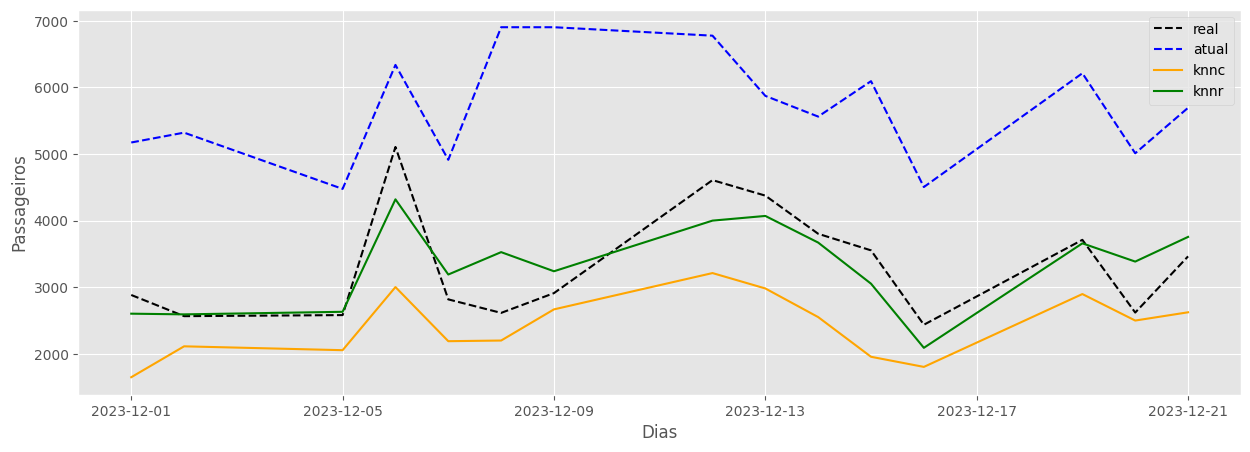

In [ ]:
plt.plot(resumo_dados['qtd_bilhetes'].head(15),'--', label='real', color='black', linewidth=1.5)
plt.plot(resumo_dados['PrevAtual'].head(15),'--', label='atual', color='blue', linewidth=1.5)
plt.plot(resumo_dados['KNNC'].head(15), label='knnc', color='orange', linewidth=1.5)
plt.plot(resumo_dados['KNNR'].head(15), label='knnr', color='green', linewidth=1.5)
plt.ylabel('Passageiros')
plt.xlabel('Dias')
plt.legend()
plt.show()

## Implementação Propria do KNN

In [ ]:
class KNN:
    def __init__(self, x, y, K=3, param='regressao'):
        self.n_amostras = len(x)
        self.n_attrs = len(x[0])
        self.param = param
        self.x, self.y, self.K = x, y, K

    # Distancia Euclidiana
    def dist_euclidiana(self, teste):
        d = {}
        for i in range(self.n_amostras):
            soma = 0
            for j in range(self.n_attrs):
                soma += math.pow(self.x[i][j] - teste[j], 2)
            d[i] = math.sqrt(soma)
        return sorted(d, key=d.get)[:self.K]
    # Calcula Pela Média
    def resultado_pela_media(self):
        return np.mean([self.y[indice] for indice in self.k_vizinhos])
    # Calcla pela Mediana
    def resultado_pela_mediana(self):
        return np.median([self.y[indice] for indice in self.k_vizinhos])
    # Calcula pela Regressão
    def resultado_pela_regressao(self, amostra):
        res = stats.linregress([self.x[indice][0] for indice in self.k_vizinhos], [self.y[indice] for indice in self.k_vizinhos])
        return res.intercept + res.slope * amostra[0]
    def resultado_pela_votacao(self,labels):
        n_votos = Counter(labels)
        vencedor, contagem_vencedor = n_votos.most_common(1)[0]
        qtd_vencedores = len([c for c in n_votos.values() if c == contagem_vencedor])
        if qtd_vencedores == 0:
            return vencedor
        if qtd_vencedores == 1:
            return vencedor
        else:
            return self.resultado_pela_votacao(labels[:qtd_vencedores-1])
    # Previsão
    def predict(self, amostra):
        self.k_vizinhos = self.dist_euclidiana(amostra)
        if (self.param == 'media'):
            return self.resultado_pela_media()
        if (self.param == 'median'):
            return self.resultado_pela_mediana()
        if (self.param == 'regressao'):
            return self.resultado_pela_regressao(amostra)
        if (self.param == 'class'):
            return self.resultado_pela_votacao([self.y[indice] for indice in self.k_vizinhos])

In [ ]:
entradas = np.array(x_train)
knn = KNN(entradas, y_train, 45,param="median")

In [ ]:
r_knn = []
for i in range(len(entradas)):
    r_knn.append( knn.predict(entradas[i]))

In [ ]:
analise_erros['KNN']=multi_class_classification(real,r_knn)

R2 Score  0.3385732477028526
Erro Quadratico Médio  4632.5875
Raiz Erro Quadratico Médio  68.06311409273013
Erro Quadratico Absoluto  49.434375
Max Erro  315.0


In [ ]:
dados_prev['KNN'] = r_knn
resumo_dados = dados_prev.groupby('gps_dataoperacao').agg({'qtd_bilhetes': 'sum','PrevAtual': 'sum','KNNC': 'sum','KNNR': 'sum','KNN': 'sum'})

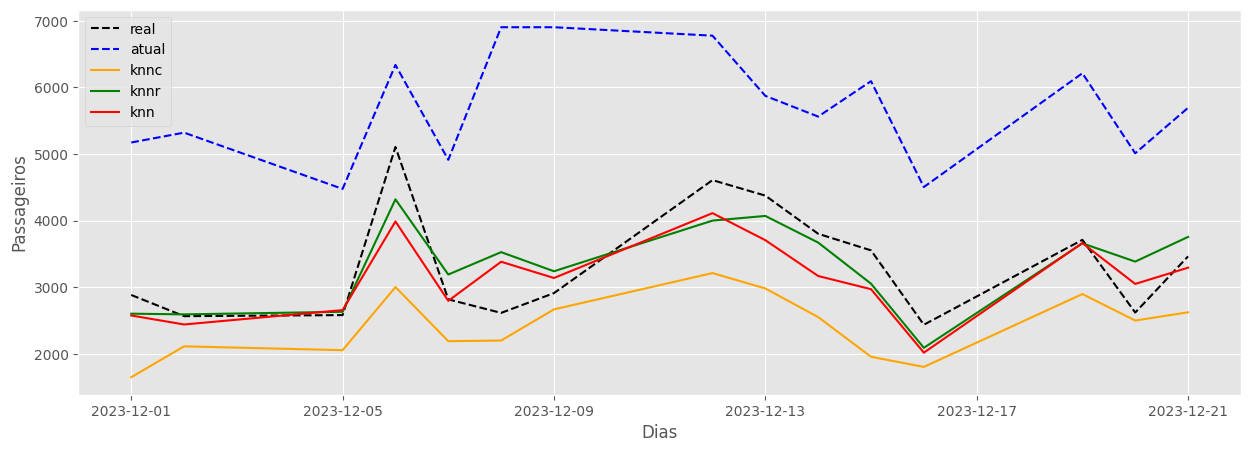

In [ ]:
plt.plot(resumo_dados['qtd_bilhetes'].head(15),'--', label='real', color='black', linewidth=1.5)
plt.plot(resumo_dados['PrevAtual'].head(15),'--', label='atual', color='blue', linewidth=1.5)
plt.plot(resumo_dados['KNNC'].head(15), label='knnc', color='orange', linewidth=1.5)
plt.plot(resumo_dados['KNNR'].head(15), label='knnr', color='green', linewidth=1.5)
plt.plot(resumo_dados['KNN'].head(15), label='knn', color='red', linewidth=1.5)
plt.ylabel('Passageiros')
plt.xlabel('Dias')
plt.legend()
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestRegressor
RFregressor = RandomForestRegressor(n_estimators = 90, random_state = 0)
RFregressor.fit(entradas, y_train)
r_rfr = RFregressor.predict(entradas)
dados_prev['RFR'] = r_rfr
resumo_dados = dados_prev.groupby('gps_dataoperacao').agg({'qtd_bilhetes': 'sum','PrevAtual': 'sum','KNNC': 'sum','KNNR': 'sum','KNN': 'sum','RFR': 'sum'})
analise_erros['RFR']=multi_class_classification(real,r_rfr)

R2 Score  0.5181577582424577
Erro Quadratico Médio  3374.789934615705
Raiz Erro Quadratico Médio  58.09294221001124
Erro Quadratico Absoluto  44.019501619247485
Max Erro  232.88242143658806


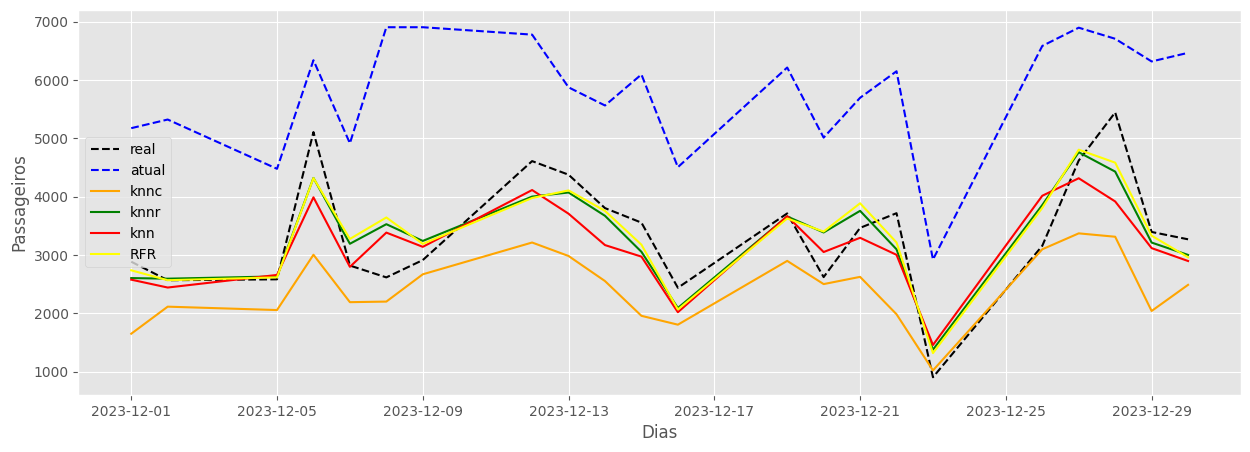

In [ ]:
plt.plot(resumo_dados['qtd_bilhetes'].head(30),'--', label='real', color='black', linewidth=1.5)
plt.plot(resumo_dados['PrevAtual'].head(30),'--', label='atual', color='blue', linewidth=1.5)
plt.plot(resumo_dados['KNNC'].head(30), label='knnc', color='orange', linewidth=1.5)
plt.plot(resumo_dados['KNNR'].head(30), label='knnr', color='green', linewidth=1.5)
plt.plot(resumo_dados['KNN'].head(30), label='knn', color='red', linewidth=1.5)
plt.plot(resumo_dados['RFR'].head(30), label='RFR', color='yellow', linewidth=1.5)
plt.ylabel('Passageiros')
plt.xlabel('Dias')
plt.legend()
plt.show()

## Conclusão
Podemos perceber uma melhoria na precisão das previsões, que se mantem selecionando outro periodo para teste.

A rotina de split_test não foi utilizada pois a mesma mistura dados de periodos diferentes ficando comprometidos devido a sazonalidade da operação de transportes

Erro Quadratico ATUAL (117.022)
Erro Quadratico R_KNNC (77.029)
Erro Quadratico R_KNNR (59.118)
Erro Quadratico KNN (68.063)
Erro Quadratico RFR (58.093)


<BarContainer object of 5 artists>

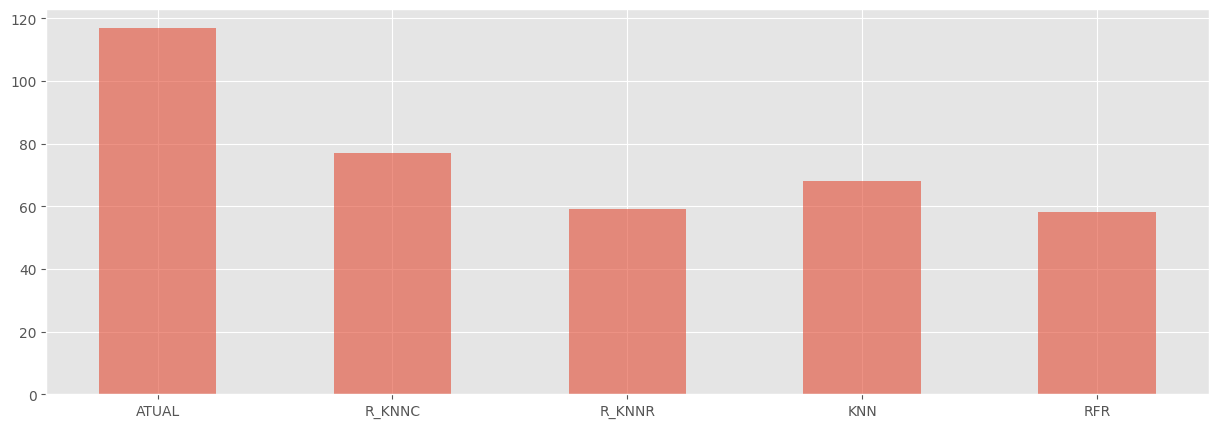

In [ ]:
grupos = analise_erros.keys()
valores = []
for g in grupos:
    valores.append(analise_erros[g][2])
    print('Erro Quadratico {} ({})'.format(g, round(analise_erros[g][2],3)))
plt.style.use("ggplot")
plt.bar(grupos, valores,.5,align='center',alpha = .6)

In [ ]:
perc_red_erro=(analise_erros['ATUAL'][2]-analise_erros['R_KNNR'][2])/analise_erros['ATUAL'][2]*100
print('Percentual Redução do Erro {}%'.format(round(perc_red_erro,2)))

Percentual Redução do Erro 49.48%


### Pegando outro periodo para teste

In [ ]:
tmp_dataset = trata_dados(dataset)
tmp_dataset = apaga_feriados(tmp_dataset)
tmp_dataset = tmp_dataset[tmp_dataset['tipodia']==1]
#tmp_dataset = tmp_dataset[tmp_dataset['Hora Uso']==17]
tmp_dataset = tmp_dataset[(tmp_dataset['gps_dataoperacao']>='2024-01-01') & (tmp_dataset['gps_dataoperacao']<='2024-01-31')]
dados_teste = tmp_dataset
dados_teste.set_index(['gps_dataoperacao'],inplace=True)
dados_teste.head(5)

,tipodia,gps_codexterno_linha,Hora Uso,gps_sentido,diasemana,qtd_bilhetes
gps_dataoperacao,,,,,,
2024-01-02,1,518,4.0,I,1,0.0
2024-01-02,1,518,5.0,I,1,221.0
2024-01-02,1,518,5.0,V,1,47.0
2024-01-02,1,518,6.0,I,1,68.0
2024-01-02,1,518,6.0,V,1,166.0


In [ ]:
x_test = dados_teste[['tipodia','Hora Uso','diasemana']]
y_test = np.array(dados_teste['qtd_bilhetes'])

In [ ]:
r_teste_atual =[]
for i,p in dados_teste.iterrows():
    r_teste_atual.append(predict_atual(dg, p['gps_codexterno_linha'], p['tipodia'], p['Hora Uso']))
erro_atual = multi_class_classification(y_test,r_teste_atual)
analise_erros['ATUAL_TEST']=erro_atual
dados_teste['PrevAtual'] = r_teste_atual

R2 Score  -1.1760312571465117
Erro Quadratico Médio  15289.361842105263
Raiz Erro Quadratico Médio  123.65015908645351
Erro Quadratico Absoluto  99.97039473684211
Max Erro  444.0


In [ ]:
r_test = RFregressor.predict(x_test)
analise_erros['KNNR_TEST']=multi_class_classification(y_test,r_test)

R2 Score  0.31672129490124024
Erro Quadratico Médio  4800.8939793260915
Raiz Erro Quadratico Médio  69.28848374243798
Erro Quadratico Absoluto  51.99165497696395
Max Erro  334.47827160493824


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [ ]:
perc_red_erro=(analise_erros['ATUAL_TEST'][2]-analise_erros['KNNR_TEST'][2])/analise_erros['ATUAL_TEST'][2]*100
print('Percentual Redução do Erro {}%'.format(round(perc_red_erro,2)))

Percentual Redução do Erro 43.96%


In [ ]:
dados_teste['RFR'] = r_test
resumo_teste = dados_teste.groupby('gps_dataoperacao').agg({'qtd_bilhetes': 'sum','PrevAtual': 'sum','RFR': 'sum'})

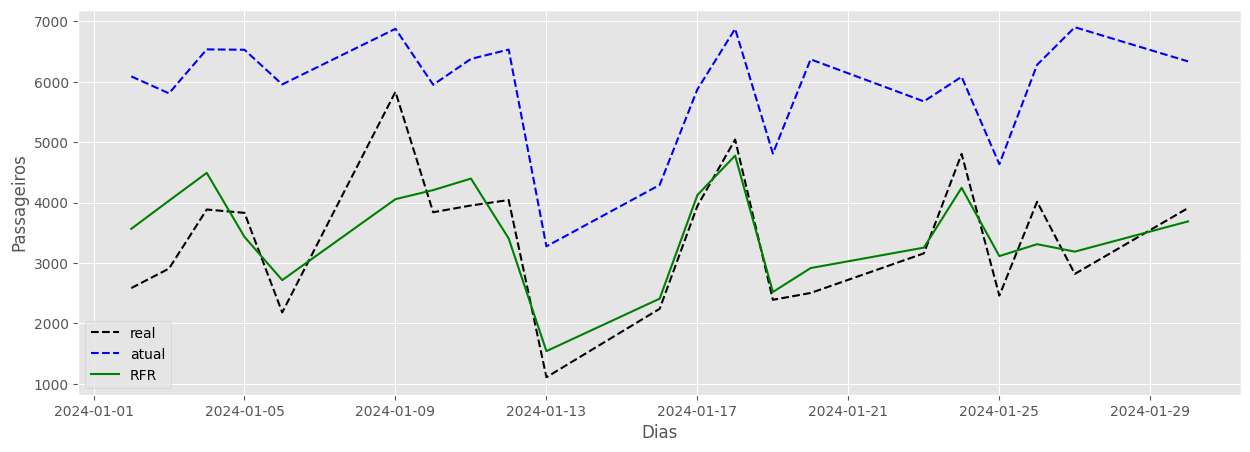

In [ ]:
plt.plot(resumo_teste['qtd_bilhetes'].head(30),'--', label='real', color='black', linewidth=1.5)
plt.plot(resumo_teste['PrevAtual'].head(30),'--', label='atual', color='blue', linewidth=1.5)
plt.plot(resumo_teste['RFR'].head(30), label='RFR', color='green', linewidth=1.5)
plt.ylabel('Passageiros')
plt.xlabel('Dias')
plt.legend()
plt.show()

In [ ]:
import joblib
joblib.dump(r_test, 'modelo-rfr.joblib')

['modelo-rfr.joblib']